<a href="https://colab.research.google.com/github/yifan-zhou19/Policy_migration/blob/master/Access_Polich_Migration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt

  
decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',
             xytext=centerPt, textcoords='axes fraction',
             va="center", ha="center", bbox=nodeType, arrowprops=arrow_args )

def createPlot():     
    fig = plt.figure(1,facecolor='white',figsize=[6,20]) 
    # 
    fig.clf() 
    


    createPlot.ax1 = plt.subplot(111,frameon=False) 
    plotNode('a decision node',(0.5,0.1),(0.1,0.5),decisionNode) 
    plotNode('a leaf node',(0.8,0.1),(0.3,0.8),leafNode) 
    plt.show() 




def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    
    
    secondDict = myTree[firstStr]
    
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
          
            numLeafs += getNumLeafs(secondDict[key])
        else : numLeafs += 1
    return numLeafs
def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else : thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

#输出预先存储的树信息
def retrieveTree(i):
    listOfTrees = [{'no surfacing':{0:'no',1:{'flippers':{0:'no',1:'yes'}}}},
                   {'no surfacing':{0:'no',1:{'flippers':{0:{'head':{0:'no',
                   1:'yes'}},1:'no'}}}}]
    #定义了两个字典
    return listOfTrees[i]

#plotTree 函数
def plotMidText(cntrpt,parentPt,txtString):
    #计算父节点与子节点的中间位置，在此处添加文本信息
    xMid = (parentPt[0] - cntrpt[0])/2.0 + cntrpt[0]
    yMid = (parentPt[1] - cntrpt[1])/2.0 + cntrpt[1]
    createPlot.ax1.text(xMid,yMid,txtString)
def plotTree(myTree,parentPt,nodeTxt):
  
    numLeafs = getNumLeafs(myTree)
    
    depth = getTreeDepth(myTree)
    
    firstStr = list(myTree.keys())[0]
    cntrpt = (plotTree.x0ff + (1.0 + float(numLeafs))/2.0/plotTree.totalW,plotTree.y0ff)
    #cntrPt
    plotMidText(cntrpt,parentPt,nodeTxt)
    
    plotNode(firstStr,cntrpt,parentPt,decisionNode)
    secondDict = myTree[firstStr]
    plotTree.y0ff = plotTree.y0ff - 1.0/plotTree.totalD
    
    for key in secondDict.keys():
         if type(secondDict[key]).__name__=='dict':
           
             plotTree(secondDict[key],cntrpt,str(key))
         else:
             plotTree.x0ff = plotTree.x0ff + 1.0/plotTree.totalW
             plotNode(secondDict[key],(plotTree.x0ff,plotTree.y0ff),cntrpt,
                      leafNode)
             plotMidText((plotTree.x0ff,plotTree.y0ff),cntrpt,str(key))
    plotTree.y0ff = plotTree.y0ff + 1.0/plotTree.totalD
def createPlot(inTree):
  
    fig = plt.figure(1,facecolor='white',figsize=[40,6]) 
    
    fig.clf()
    
    axprops = dict(xticks=[],yticks=[])
    
    createPlot.ax1 = plt.subplot(111,frameon=False,**axprops)
    
    plotTree.totalW = float(getNumLeafs(inTree))
    
    plotTree.totalD = float(getTreeDepth(inTree))
    
    plotTree.x0ff = -0.5/plotTree.totalW;
    
    plotTree.y0ff = 1.0;
    plotTree(inTree, (0.5,1.0), '')   
    plt.show()

In [3]:
#define ABAC policy (university samples)
U=[{'uid':'applicant1','position':'applicant'},
 {'uid':'csStu1','position':'student','udepartment':'cs','crsTaken':['cs101'],'crsTaught':['cs601']},
 {'uid':'csStu2','position':'student','udepartment':'cs','crsTaken':['cs101','cs601']},
 {'uid':'csFac1','position':'faculty','udepartment':'cs','crsTaught':['cs101']},
 {'uid':'csFac2','position':'faculty','udepartment':'cs','crsTaught':['cs601']},
 {'uid':'csChair','isChair':True,'udepartment':'cs'},
 {'uid':'eeFac1','position':'faculty','udepartment':'ee','crsTaught':['ee101']},
 {'uid':'eeFac2','position':'faculty','udepartment':'ee','crsTaught':['ee601']},
 {'uid':'eeChair','isChair':True,'udepartment':'ee'},
 {'uid':'registrar1','position':'staff','udepartment':'registrar'},
 {'uid':'admissions1','position':'staff','udepartment':'admissions'},
]
R=[{'rid':'application1','type':'application','student':'applicant1'},
 {'rid':'csStu1application','type':'application','student':'csStu1'},
 {'rid':'csStu2application','type':'application','student':'csStu2'},
 {'rid':'eeStu1application','type':'application','student':'eeStu1'},
 {'rid':'eeStu2application','type':'application','student':'eeStu2'},
 {'rid':'cs101gradebook','type':'gradebook','rdepartment':'cs','crs':'cs101'},
 {'rid':'cs601gradebook','type':'gradebook','rdepartment':'cs','crs':'cs601'},
 {'rid':'ee101gradebook','type':'gradebook','rdepartment':'ee','crs':'ee101'},
 {'rid':'ee601gradebook','type':'gradebook','rdepartment':'ee','crs':'ee601'},
 {'rid':'cs101roster','type':'roster','rdepartment':'cs','crs':'cs101'},
 {'rid':'cs601roster','type':'roster','rdepartment':'cs','crs':'cs601'},
 {'rid':'ee101roster','type':'roster','rdepartment':'ee','crs':'ee101'},
 {'rid':'ee601roster','type':'roster','rdepartment':'ee','crs':'ee601'},
 {'rid':'csStu1trans','type':'transcript','rdepartment':'cs','student':'csStu1'},
 {'rid':'csStu2trans','type':'transcript','rdepartment':'cs','student':'csStu2'},
 {'rid':'eeStu1trans','type':'transcript','rdepartment':'ee','student':'eeStu1'},
 {'rid':'eeStu2trans','type':'transcript','rdepartment':'ee','student':'eeStu2'},

]
UA=['position','udepartment','crsTaken','crsTaught','isChair','uid']
RA=['type','student','rdepartment', 'crs','rid']
O=['readMyScores','addScore', 'readScore','changeScore', 'assignGrade','read','write','checkStatus','setStatus']
RU=[{# a user can read his/her own scores in gradebooks for courses he/she has taken. 
     # change in and = into is
  'expressions':[{'eu':{ },'er':{'type':[('is','gradebook')],'crs':[('in','crsTaken')]}}],'operations':['readMyScores'],'decision':'allow'}, 
# a user (the instructor or TA) can add scores and read scores in the gradebook for courses he/she is teaching. 
 {'expressions':[{'eu':{ },'er':{'type':[('is','gradebook')],'crs':[('in','crsTaught')]}}],'operations':['addScore', 'readScore'],'decision':'allow'}, 
 # the instructor for a course (i.e., a faculty teaching the course) can change scores and assign grades in the gradebook for that course. 
{'expressions':[{'eu':{'position':[('is','faculty')]},'er':{'type':[('is','gradebook')],'crs':[('in','crsTaught')]}}],'operations':['changeScore','assignGrade'],'decision':'allow'}, 
 # a user in the registrar's office can read and modify all rosters.
{'expressions':[{'eu':{'udepartment':[('is','registrar')]},'er':{'type':[('is','roster')]}}],'operations':['read','write'],'decision':'allow'}, 
# the instructor for a course (i.e., a faculty teaching the course) can read the course roster
{'expressions':[{'eu':{'position':[('is','faculty')]},'er':{'type':[('is','roster')],'crs':[('in','crsTaught')]}}],'operations':['read'],'decision':'allow'}, 
# a user can read his/her own transcript.
{'expressions':[{'eu':{ },'er':{'type':[('is','transcript')],'student':[('=','uid')]}}],'operations':['read'],'decision':'allow'}, 
#the chair of a department can read the transcripts of all students in that department.
{'expressions':[{'eu':{'isChair':[('is',True)]},'er':{'type':[('is','transcript')],'rdepartment':[('=','udepartment')]}}],'operations':['read'],'decision':'allow'}, 
# a user in the registrar's office can read every student's transcript.
{'expressions':[{'eu':{'udepartment':[('is','registrar')]},'er':{'type':[('is','transcript')]}}],'operations':['read'],'decision':'allow'}, 
# a user can check the status of his/her own application 
{'expressions':[{'eu':{ },'er':{'type':[('is','application')],'student':[('=','uid')]}}],'operations':['checkStatus'],'decision':'allow'}, 
# a user in the admissions office can read, and update the status of, every application. 
{'expressions':[{'eu':{'udepartment':[('is','admissions')]},'er':{'type':[('is','application')]}}],'operations':['read','setStatus'],'decision':'allow'}
]
def dU(user,attribute):
  if attribute in user.keys():
    return user[attribute]

def dR(resource,attribute):
  if attribute in resource.keys():
    return resource[attribute]

ABAC_university=(U,R,O,UA,RA,dU,dR,RU)


In [6]:

def satisfied(u,r,expressions):
  for expression in expressions:
    eu=expression['eu']
    er=expression['er']
    #for all the keys in eu get the constrina of this key
    #if u does not satisfy this const return false
    for key in eu.keys():
      for (op,c) in eu[key]:
        #op,c=eu[key]
        #print(op,c)
        if op == 'is':
          if dU(u,key) != c:
            return False

    #for all the keys in er get the constrinat of the key
    for key in er.keys():
      for (op,c) in er[key]:
        #print(op,c)
        #op,c=er[key]
        if(dR(r,key)==None):
          return False
        if op =='is':
          if dR(r,key)!=c:
        #  print(dR(r,key),c)
            return False
        elif op == '=':
          if dR(r,key)!=dU(u,c) and dR(r,key)!=dR(r,c):
            return False
        elif op == 'in':
          if dU(u,c)==None and dR(r,c)==None:
            return False
          if type(dU(u,c)==list) and dU(u,c)!=None:
          #print(dU(u,c))
            if dR(r,key) not in dU(u,c):
              return False
          if type(dR(r,c)==list) and dR(r,c)!=None:
          #print(dU(u,c))
            if dR(r,key) not in dR(r,c):
              return False
  
  return True


def check_ABAC_policy(request,abac_policy):
  u,r,o =request
  _,_,_,_,_,_,_,rules = abac_policy
  for rule in rules:
    if o in rule['operations']:
      if satisfied(u,r,rule['expressions']):
        return True
  return False

# check the ABAC policy 
number_allow=0
number_deny=0
for u in U:
  for r in R:
    for o in O:
      if(check_ABAC_policy((u,r,o),ABAC_university)==True):
        number_allow= number_allow+1
      else:
        number_deny =number_deny +1 
        #print(f'{u}\n{r}\n{o}\n \n')

print(f'For ABAC policy:\nNumber of allow:{number_allow}\nNumber of deny:{number_deny}')

#print(f'{check_ABAC_policy((U[6],R[7],"readMyScores"),ABAC_university)}\n{U[6]}\n{R[7]}')
#print(f'{check_ABAC_policy((U[3],R[5],"addScore"),ABAC_university)}\n{U[3]}\n{R[5]}')
#print(f'Loss at epo {epoch}: {losses/len(training_data)}')


For ABAC policy:
Number of allow:56
Number of deny:1627


In [7]:
# Bulid the translator 

# Define the structure of the permission tree

class Node:
  def __init__(self):
    self.label = []
    self.edges = [] #list of edges
    self.parent_node = None 
    #self.child_node = None

  def add_edge(self,edge): #add one child node for self thourgh the edge
    self.edges.append(edge)


class Edge:
  def __init__(self,pre_node,next_node):
    self.label = []
    self.pre_node = pre_node
    self.next_node = next_node

class Permission_tree:
  def __init__(self,rootObj):
    self.root = rootObj



def get_all_branches(node):
  if len(node.edges)==0:
    return [[node.label]]
  branches = []
  for e in node.edges:
    for sub_branch in get_all_branches(e.next_node):
      branches.append([node.label,e.label]+sub_branch)
  return branches

root = Node()
OPT = Permission_tree(root)


In [23]:
def find_the_first_constraint(user_cons,constraints_order):
  result = None
  for uc in constraints_order: # uc is in form of (key,value)
    if uc in user_cons.items():
      del user_cons[uc[0]]
      result = uc
      break
  if result == None:
    uc = sorted(user_cons.items())[0]
    constraints_order.append(uc)
    del user_cons[uc[0]]
    result = uc
  return result






# Get the ordered rule

#print(len(RU[3]['expressions'][0]['eu']))
#print(RU[3]['expressions'][0]['eu'])
Ordered_RU=sorted(RU,key=lambda s: len(s['expressions'][0]['eu']) ) #sorted according the number of user constraints
#print(Ordered_RU)
#print(RU)
constraints_order=[]
permission=[]
root = Node()
opt_university = Permission_tree(root)
for rule in Ordered_RU:
  user_cons=rule['expressions'][0]['eu'].copy()
  resource_cons=rule['expressions'][0]['er'].copy()
  operations=rule['operations'].copy()
  current_node = opt_university.root
  #print(len(user_cons),user_cons)
  while len(user_cons)!=0:
    #print(user_cons,constraints_order)
    uc = find_the_first_constraint(user_cons,constraints_order)
    print(uc,constraints_order)
#  for uc_key in user_cons.keys():
    #print({uc_key:user_cons[uc_key]})

    new_node = Node()
    new_node.parent_node=current_node
    new_edge = Edge(current_node,new_node)
#    new_edge.label.append({uc_key:user_cons[uc_key]})
    new_edge.label.append(uc)
    current_node.add_edge(new_edge)
    current_node = current_node.edges[-1].next_node
  current_node.label.append((resource_cons,operations))
  if (resource_cons,operations) not in permission:
    permission.append((resource_cons,operations))


branches=get_all_branches(opt_university.root)
branches.append([branches[0][0]])
print("Result:")
for b in branches:
  print(b)
print("Order")
print(constraints_order)
print("Permissions")
print(permission)


('position', [('is', 'faculty')]) [('position', [('is', 'faculty')])]
('udepartment', [('is', 'registrar')]) [('position', [('is', 'faculty')]), ('udepartment', [('is', 'registrar')])]
('position', [('is', 'faculty')]) [('position', [('is', 'faculty')]), ('udepartment', [('is', 'registrar')])]
('isChair', [('is', True)]) [('position', [('is', 'faculty')]), ('udepartment', [('is', 'registrar')]), ('isChair', [('is', True)])]
('udepartment', [('is', 'registrar')]) [('position', [('is', 'faculty')]), ('udepartment', [('is', 'registrar')]), ('isChair', [('is', True)])]
('udepartment', [('is', 'admissions')]) [('position', [('is', 'faculty')]), ('udepartment', [('is', 'registrar')]), ('isChair', [('is', True)]), ('udepartment', [('is', 'admissions')])]
Result:
[[({'type': [('is', 'gradebook')], 'crs': [('in', 'crsTaken')]}, ['readMyScores']), ({'type': [('is', 'gradebook')], 'crs': [('in', 'crsTaught')]}, ['addScore', 'readScore']), ({'type': [('is', 'transcript')], 'student': [('=', 'uid')

In [24]:
def find_edge(e,list):
  for i in list:
    if e.label == i.label:
      return i
  return None

def merge_edges(node):
  if len(node.edges)==0:
    return node 
  new_edges=[]
  for e in node.edges:
    if find_edge(e,new_edges)==None: # label
      new_edges.append(e)
    else:
      old_e = find_edge(e,new_edges) # the same edge label
      for i in old_e.next_node.label:
        if i not in e.next_node.label:
          e.next_node.label.append(i) #merge permission
      e.next_node=merge_edges(e.next_node)
      new_edges.remove(old_e)
      new_edges.append(e)
  return node







merge_edges(opt_university.root)



Now we have the ordered permission tree opt_university.
{'p0/p1/p2/p3/': {'c0/': 'p6/p4/', 'c1/': 'p8/p5/', 'c2/': 'p7/', 'c3/': 'p9/'}}


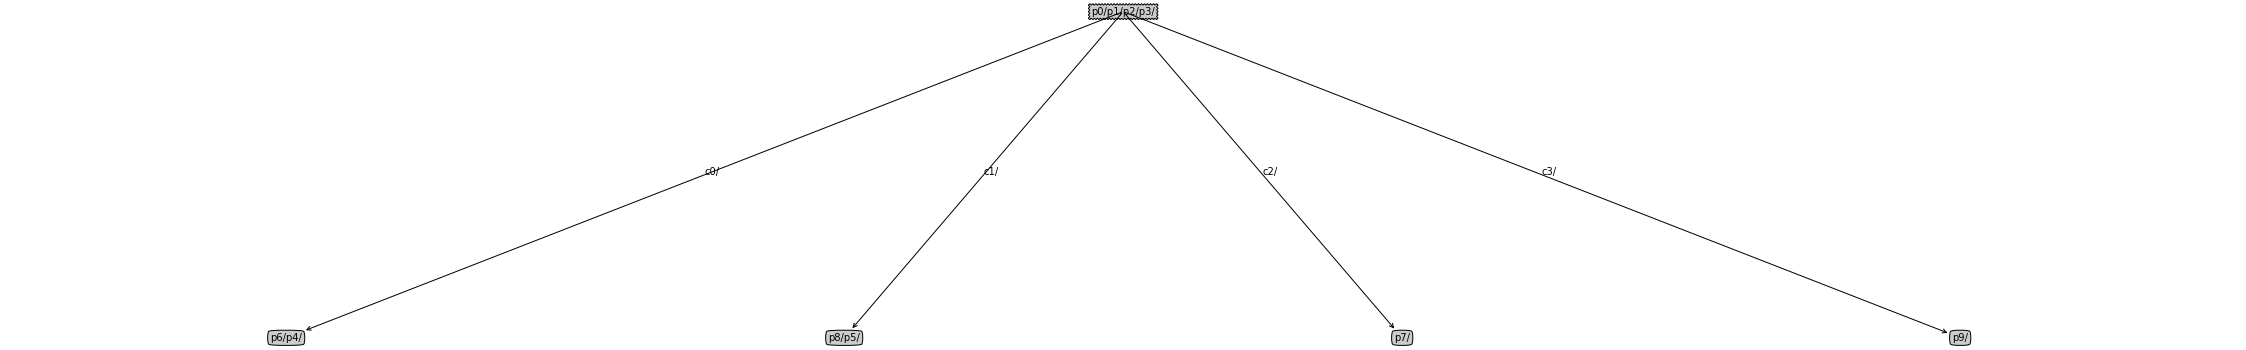

In [10]:
def get_item_id(item,list):
  id = 0
  while(id<len(list)):
    if item == list[id]:
      return id
    id = id + 1
  return None

def get_tree(node):
  nkey = ''
  for item in node.label:
    if get_item_id(item,permission)!=None:
      nkey = nkey + 'p'+ str(get_item_id(item,permission)) + '/'
      
  if len(node.edges)==0:
    return nkey  # leaf nodes

 
  
  tree = dict()
  subtree=dict()
  for e in node.edges: 
    ekey = ''
    for item in e.label:
      if get_item_id(item,constraints_order)!=None:
        ekey = ekey + 'c'+ str(get_item_id(item,constraints_order)) + '/'
    subtree[ekey]=get_tree(e.next_node)
  tree[nkey]=subtree
   # for sub_branch in get_all_branches(e.next_node):
   #   branches.append([node.label,e.label]+sub_branch)
  return tree

def visualization(pt):
  tree = get_tree(pt.root)
  print(tree)
  createPlot(tree)
print("Now we have the ordered permission tree opt_university.")
#print(opt_university)
visualization(opt_university)

{'p0/p1/p2/p3/': {'c0/': 'p6/p4/', 'c1/': 'p8/p5/', 'c2/': 'p7/', 'c3/': 'p9/'}}


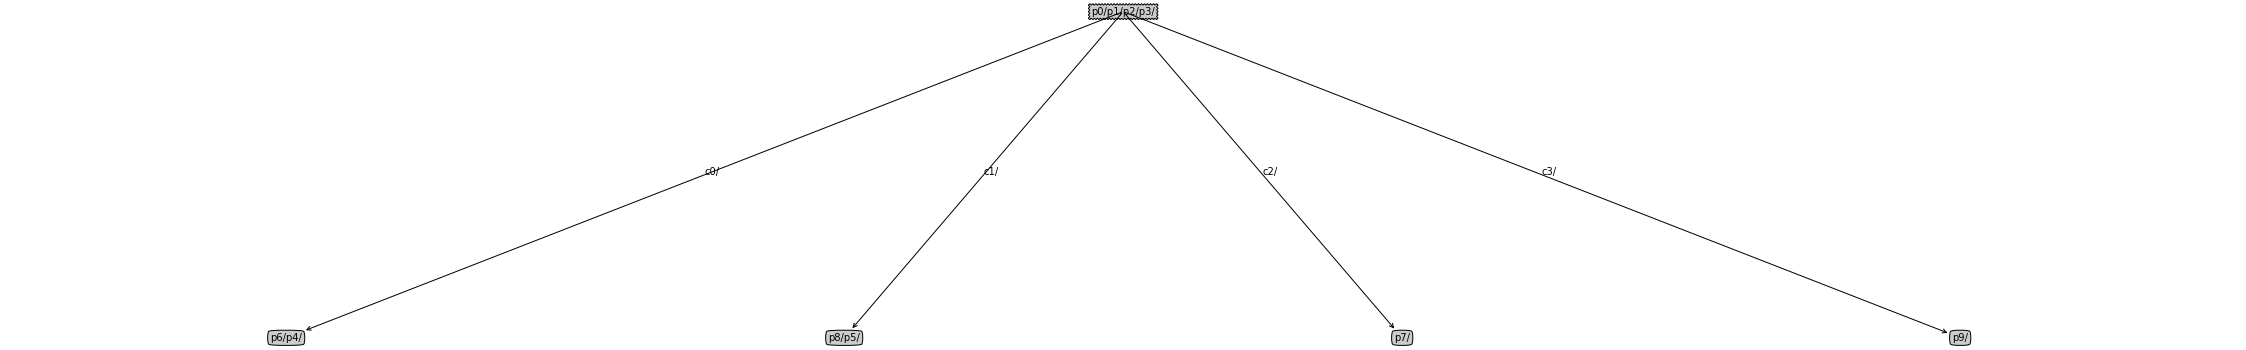

{'': {'c15/': {'p70/': {'c0/': {'': {'c19/': 'p84/p88/', 'c20/': 'p85/p89/', 'c21/': 'p86/p90/', 'c22/': 'p87/p91/'}}, 'c1/': 'p8/p5/', 'c2/': {'': {'c26/': 'p92/', 'c27/': 'p93/', 'c28/': 'p94/', 'c29/': 'p95/'}}, 'c3/': 'p9/'}}, 'c16/': {'p71/': {'c0/': {'': {'c19/': 'p84/p88/', 'c20/': 'p85/p89/', 'c21/': 'p86/p90/', 'c22/': 'p87/p91/'}}, 'c1/': 'p8/p5/', 'c2/': {'': {'c26/': 'p92/', 'c27/': 'p93/', 'c28/': 'p94/', 'c29/': 'p95/'}}, 'c3/': 'p9/'}}, 'c17/': {'p72/': {'c0/': {'': {'c19/': 'p84/p88/', 'c20/': 'p85/p89/', 'c21/': 'p86/p90/', 'c22/': 'p87/p91/'}}, 'c1/': 'p8/p5/', 'c2/': {'': {'c26/': 'p92/', 'c27/': 'p93/', 'c28/': 'p94/', 'c29/': 'p95/'}}, 'c3/': 'p9/'}}, 'c18/': {'p73/': {'c0/': {'': {'c19/': 'p84/p88/', 'c20/': 'p85/p89/', 'c21/': 'p86/p90/', 'c22/': 'p87/p91/'}}, 'c1/': 'p8/p5/', 'c2/': {'': {'c26/': 'p92/', 'c27/': 'p93/', 'c28/': 'p94/', 'c29/': 'p95/'}}, 'c3/': 'p9/'}}, 'c19/': {'p74/': {'c0/': {'': {'c19/': 'p84/p88/', 'c20/': 'p85/p89/', 'c21/': 'p86/p90/', 'c2

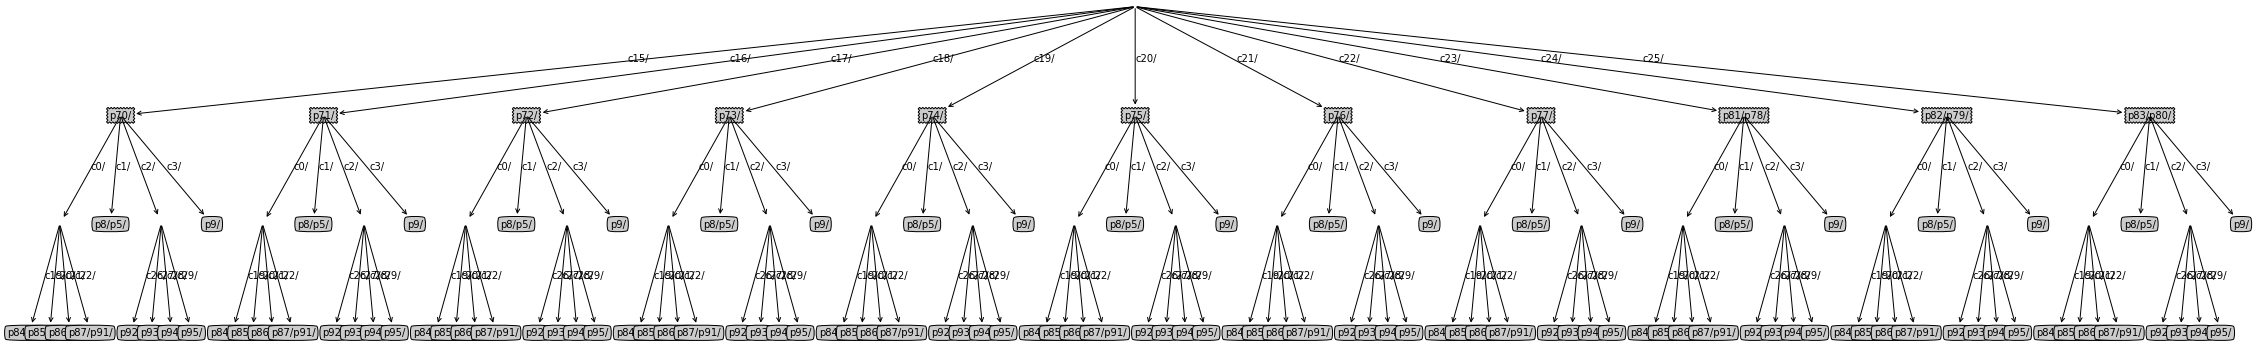

[[]]
[[], [('crs', [('in', 'crsTaken'), ('is', 'cs101')])], [({'type': [('is', 'gradebook')], 'crs': [('in', 'crsTaken'), ('is', 'cs101')]}, ['readMyScores'])]]
[[], [('crs', [('in', 'crsTaken'), ('is', 'cs101')])], [({'type': [('is', 'gradebook')], 'crs': [('in', 'crsTaken'), ('is', 'cs101')]}, ['readMyScores'])], [('position', [('is', 'faculty')])], []]
[[], [('crs', [('in', 'crsTaken'), ('is', 'cs101')])], [({'type': [('is', 'gradebook')], 'crs': [('in', 'crsTaken'), ('is', 'cs101')]}, ['readMyScores'])], [('udepartment', [('is', 'registrar')])], [({'type': [('is', 'roster')]}, ['read', 'write'])]]
[[], [('crs', [('in', 'crsTaken'), ('is', 'cs101')])], [({'type': [('is', 'gradebook')], 'crs': [('in', 'crsTaken'), ('is', 'cs101')]}, ['readMyScores'])], [('position', [('is', 'faculty')])], []]
[[], [('crs', [('in', 'crsTaken'), ('is', 'cs101')])], [({'type': [('is', 'gradebook')], 'crs': [('in', 'crsTaken'), ('is', 'cs101')]}, ['readMyScores'])], [('isChair', [('is', True)])], []]
[[]

In [27]:
import copy
attributes={'crs':['cs101','cs601','ee101','ee601'],'student':['csStu1','csStu2','applicant1'],'rdepartment':['registrar','admissions','ee','cs']}

def add_resource_constraint(node):
  length = len(node.edges)
  node_edges= copy.deepcopy(node.edges)
  need_to_remove=[]
  first = False
  for (er,operations) in node.label:
    flag = False
    for key in er.keys():# Only one variable constriants
      if (flag == True): 
        flag = False
        break
      for (op,c) in er[key]:
        if (flag==True):
          break
        elif op =='=' or op=='in': # find the (op,c) and er[key]
          flag = True
          if first == False:
            node.edges=[]
            first = True
          need_to_remove.append((er,operations))
          #print((er,operations))
          for value in attributes[key]:
            #print(er,operations,key,op,value,)
 
            er_new=copy.deepcopy(er)
            #print(er_new)
            #er_new[key].remove((op,c))
            er_new[key].append(('is',value))
            #print(er_new)
            new_node = Node()
            new_node.edges=node_edges
            new_node.parent_node=node
            new_node.label=[(er_new,operations)]
            if (er_new,operations) not in permission:
              permission.append((er_new,operations))
            new_edge = Edge(node,new_node)
            #er_new[key].remove((op,c))
            new_edge.label=[(key,er_new[key])]
            #if (op =='='):
            #  new_edge.label=[(c,er_new[key])] # change key into c
            if (key,er_new[key]) not in constraints_order:
                constraints_order.append((key,er_new[key]))
            
            #elif (op=='in'):
            #  new_edge.label=[(c,('is',[value]))]
            node.edges.append(new_edge)
            #if (key,er_new[key]) not in constraints_order:
            #    constraints_order.append((key,er_new[key]))
            
  for i in need_to_remove:
    node.label.remove(i)
  if length==0:  
    return node
  else:
    for e in node_edges:
      e.next_node=add_resource_constraint(e.next_node)

opt_de=copy.deepcopy(opt_university)
popt=add_resource_constraint(opt_de.root)
merge_edges(opt_de.root)
#print(opt_de)
visualization(opt_university)
visualization(opt_de)
def get_all_Branches(node):
  if len(node.edges)==0:
    return [[node.label]]
  branches = [[node.label]]
  for e in node.edges:
    for sub_branch in get_all_Branches(e.next_node):
      same_condition=True
      i = 1
      while i < len(sub_branch):
        label = sub_branch[i]
        for (key_e,value_e) in e.label:
          for (k,v) in label:
            if(key_e==k and v != value_e):
              same_condition=False

        i= i+2

      if(same_condition ==True):
        branches.append([node.label,e.label]+sub_branch)
  return branches
branches_de=get_all_Branches(opt_de.root)
for i in branches_de:
  print(i)
print(constraints_order)
print(permission)


In [18]:
def get_all_Branches(node):
  if len(node.edges)==0:
    return [[node.label]]
  branches = [[node.label]]
  for e in node.edges:
    for sub_branch in get_all_Branches(e.next_node):
      same_condition=True
      i = 1
      while i < len(sub_branch):
        label = sub_branch[i]
        for (key_e,value_e) in e.label:
          for (k,v) in label:
            if(key_e==k and v != value_e):
              same_condition=False

        i= i+2

      if(same_condition ==True):
        branches.append([node.label,e.label]+sub_branch)
  return branches
branches_de=get_all_Branches(opt_de.root)

In [ ]:
for i in range(len(permission)):
  print(i,permission[i])
for i in range(len(constraints_order)):
  print(i,constraints_order[i])

0 ({'type': [('is', 'gradebook')], 'crs': [('in', 'crsTaken')]}, ['readMyScores'])
1 ({'type': [('is', 'gradebook')], 'crs': [('in', 'crsTaught')]}, ['addScore', 'readScore'])
2 ({'type': [('is', 'transcript')], 'student': [('=', 'uid')]}, ['read'])
3 ({'type': [('is', 'application')], 'student': [('=', 'uid')]}, ['checkStatus'])
4 ({'type': [('is', 'gradebook')], 'crs': [('in', 'crsTaught')]}, ['changeScore', 'assignGrade'])
5 ({'type': [('is', 'roster')]}, ['read', 'write'])
6 ({'type': [('is', 'roster')], 'crs': [('in', 'crsTaught')]}, ['read'])
7 ({'type': [('is', 'transcript')], 'rdepartment': [('=', 'udepartment')]}, ['read'])
8 ({'type': [('is', 'transcript')]}, ['read'])
9 ({'type': [('is', 'application')]}, ['read', 'setStatus'])
10 ({'type': [('is', 'gradebook')], 'crs': [('is', 'cs101')]}, ['readMyScores'])
11 ({'type': [('is', 'gradebook')], 'crs': [('is', 'cs601')]}, ['readMyScores'])
12 ({'type': [('is', 'gradebook')], 'crs': [('is', 'ee101')]}, ['readMyScores'])
13 ({'ty

In [29]:

import copy
# RBAC
#satisfied(u,r,expressions)
attributes={'crs':['cs101','cs601','ee101','ee601'],'student':['csStu1','csStu2','applicant1'],'rdepartment':['registrar','admissions','ee','cs']}

# Use nodes and some of the resource attributes information to generate RPA (some role might not be used in the user-role assignment)

# create role-permission assignment
# for every last node in each branch (b[-1])
# create a role which include all eu_operation(no variable) pairs
# for each eu_operation pair(variable), each possible value create a role (eu_op now they dont have variables)
BRPA = dict() #{'branch_id':{'role_id':[(r,o),(r,o)]}}

for i in branches:
  print(i)
for i in range(len(branches)):
  BRPA[i]=dict()
role_num=0
for i in range(len(branches)): #get b[-1]
  BRPA[i][role_num]=copy.deepcopy(branches[i][-1])  
  old_role_id = role_num
  role_num = role_num+1
  
  for (er,operations) in branches[i][-1]:#( dic, list) 
    #print(branches[i][-1])
    flag = False
    for key in er.keys():
      if(flag == True): # Only one variable constriants
        break
      for (op,c) in er[key]:
        if(flag==True):
          break
        if op =='=' or op=='in':
          flag = True
          #print(BRPA[i][role_num-1])
          #print((er,operations))
          BRPA[i][old_role_id].remove((er,operations))
          for value in attributes[key]:
            er_new=copy.deepcopy(er)
            er_new[key].append(('is',value))
            BRPA[i][role_num]=[(er_new,operations)]
            role_num=role_num+1
        

for i in BRPA.keys():
  print(i,BRPA[i])
  #for key in BRPA[i].keys():
  #  print(BRPA[i][key])



[[({'type': [('is', 'gradebook')], 'crs': [('in', 'crsTaken')]}, ['readMyScores']), ({'type': [('is', 'gradebook')], 'crs': [('in', 'crsTaught')]}, ['addScore', 'readScore']), ({'type': [('is', 'transcript')], 'student': [('=', 'uid')]}, ['read']), ({'type': [('is', 'application')], 'student': [('=', 'uid')]}, ['checkStatus'])], [('position', [('is', 'faculty')])], [({'type': [('is', 'gradebook')], 'crs': [('in', 'crsTaught')]}, ['changeScore', 'assignGrade'])]]
[[({'type': [('is', 'gradebook')], 'crs': [('in', 'crsTaken')]}, ['readMyScores']), ({'type': [('is', 'gradebook')], 'crs': [('in', 'crsTaught')]}, ['addScore', 'readScore']), ({'type': [('is', 'transcript')], 'student': [('=', 'uid')]}, ['read']), ({'type': [('is', 'application')], 'student': [('=', 'uid')]}, ['checkStatus'])], [('udepartment', [('is', 'registrar')])], [({'type': [('is', 'roster')]}, ['read', 'write'])]]
[[({'type': [('is', 'gradebook')], 'crs': [('in', 'crsTaken')]}, ['readMyScores']), ({'type': [('is', 'grad

In [30]:


RPA = dict() 
for i in range(role_num):
  RPA[i]=[]
  

# create user-role assignment
# find every branch that u satisfied 
# assign u to role such that thr role has the permission of ro 
URA = dict()
for u in U:
  URA[u['uid']]=[] #list of roles
  #role_id=0
  for bid in range(len(branches)):
    for r in R:
      for o in O:
        #({'type': ('is', 'gradebook'), 'crs': ('in', 'crsTaught')}, ['addScore', 'readScore'])-> pc
        for role_id in BRPA[bid].keys():

          if len(BRPA[bid][role_id])==0:
            continue
          i = 1
          eu = dict()
          #er=dict()
          while i < len(branches[bid]):
            for (key,value) in branches[bid][i]:
              eu[key]=value

            i = i +2
          for (er,operations) in BRPA[bid][role_id]:#branches[bid][-1]:
            #er.update(er_small)
            expressions=[{'eu':eu,'er':er}]
            if satisfied(u,r,expressions) and o in operations:
              if (r,o) not in RPA[role_id]:
                RPA[role_id].append((r,o))
              if role_id not in URA[u['uid']]:
                URA[u['uid']].append(role_id)


        #  for (er,operations) in branches[bid][-1]: #( dic, list) b[-1] is a list

print(RPA)
print(URA)

#print(RPA)
#print(URA)

def check_RBAC_policy(request,RPA,URA):
  u,r,o =request
  for role_id in URA[u['uid']]:
    if (r,o) in RPA[role_id]:
      return True

  return False

# check the RBAC policy 
number_allow=0
number_deny=0
for u in U:
  for r in R:
    for o in O:
      if(check_RBAC_policy((u,r,o),RPA,URA)==True):
        number_allow= number_allow+1
      else:
        number_deny =number_deny +1 
        #print(f'{u}\n{r}\n{o}\n \n')

print(f'For RBAC:\nNumber of allow:{number_allow}\nNumber of deny:{number_deny}')

# check the ABAC policy 
number_allow=0
number_deny=0
for u in U:
  for r in R:
    for o in O:
      if(check_ABAC_policy((u,r,o),ABAC_university)==True):
        number_allow= number_allow+1
      else:
        number_deny =number_deny +1 
        #print(f'{u}\n{r}\n{o}\n \n')

print(f'For ABAC:\nNumber of allow:{number_allow}\nNumber of deny:{number_deny}')


#number_allow=0
#number_deny=0

correct=0
for u in U:
  for r in R:
    for o in O:
      if (check_ABAC_policy((u,r,o),ABAC_university)==True and check_RBAC_policy((u,r,o),RPA,URA)==False):
        print(f'TF{u} {r} {o}')
      elif (check_ABAC_policy((u,r,o),ABAC_university)==False and check_RBAC_policy((u,r,o),RPA,URA)==True):
        print(f'FT{u} {r} {o}')
        #number_allow= number_allow+1
      elif (check_ABAC_policy((u,r,o),ABAC_university)==True and check_RBAC_policy((u,r,o),RPA,URA)==True):
        correct = correct +1
      elif (check_ABAC_policy((u,r,o),ABAC_university)==False and check_RBAC_policy((u,r,o),RPA,URA)==False):
        correct = correct +1
        #number_deny =number_deny +1 
        #print(f'{u}\n{r}\n{o}\n \n')

print(f'For number of correct:{correct}')


{0: [], 1: [({'rid': 'cs101gradebook', 'type': 'gradebook', 'rdepartment': 'cs', 'crs': 'cs101'}, 'changeScore'), ({'rid': 'cs101gradebook', 'type': 'gradebook', 'rdepartment': 'cs', 'crs': 'cs101'}, 'assignGrade')], 2: [({'rid': 'cs601gradebook', 'type': 'gradebook', 'rdepartment': 'cs', 'crs': 'cs601'}, 'changeScore'), ({'rid': 'cs601gradebook', 'type': 'gradebook', 'rdepartment': 'cs', 'crs': 'cs601'}, 'assignGrade')], 3: [({'rid': 'ee101gradebook', 'type': 'gradebook', 'rdepartment': 'ee', 'crs': 'ee101'}, 'changeScore'), ({'rid': 'ee101gradebook', 'type': 'gradebook', 'rdepartment': 'ee', 'crs': 'ee101'}, 'assignGrade')], 4: [({'rid': 'ee601gradebook', 'type': 'gradebook', 'rdepartment': 'ee', 'crs': 'ee601'}, 'changeScore'), ({'rid': 'ee601gradebook', 'type': 'gradebook', 'rdepartment': 'ee', 'crs': 'ee601'}, 'assignGrade')], 5: [({'rid': 'cs101roster', 'type': 'roster', 'rdepartment': 'cs', 'crs': 'cs101'}, 'read'), ({'rid': 'cs101roster', 'type': 'roster', 'rdepartment': 'cs', 

In [34]:


RPA = dict() 
for i in range(len(branches_de)):
  RPA[i]=[]
  

# create user-role assignment
# find every branch that u satisfied 
# assign u to role such that thr role has the permission of ro 
URA = dict()
for u in U:
  URA[u['uid']]=[] #list of roles
  #role_id=0
  for bid in range(len(branches_de)):
    for r in R:
      for o in O:
        #({'type': ('is', 'gradebook'), 'crs': ('in', 'crsTaught')}, ['addScore', 'readScore'])-> pc
        #for role_id in BRPA[bid].keys():
        if(True):

          i = 1
          eu = dict()
          #er=dict()
          while i < len(branches_de[bid]):
            for (key,value) in branches_de[bid][i]:
              if(key in UA):
                eu[key]=value

            i = i +2
          for (er,operations) in branches_de[bid][-1]:#branches[bid][-1]:BRPA[bid][role_id]
            #er.update(er_small)
            expressions=[{'eu':eu,'er':er}]
            #print(expressions)
            if satisfied(u,r,expressions) and o in operations:
              if (r,o) not in RPA[bid]:
                RPA[bid].append((r,o))
              if bid not in URA[u['uid']]:
                URA[u['uid']].append(bid)


        #  for (er,operations) in branches[bid][-1]: #( dic, list) b[-1] is a list

print(RPA)
print(URA)

#print(RPA)
#print(URA)

def check_RBAC_policy(request,RPA,URA):
  u,r,o =request
  for role_id in URA[u['uid']]:
    if (r,o) in RPA[role_id]:
      return True

  return False

# check the RBAC policy 
number_allow=0
number_deny=0
for u in U:
  for r in R:
    for o in O:
      if(check_RBAC_policy((u,r,o),RPA,URA)==True):
        number_allow= number_allow+1
      else:
        number_deny =number_deny +1 
        #print(f'{u}\n{r}\n{o}\n \n')

print(f'For RBAC:\nNumber of allow:{number_allow}\nNumber of deny:{number_deny}')

# check the ABAC policy 
number_allow=0
number_deny=0
for u in U:
  for r in R:
    for o in O:
      if(check_ABAC_policy((u,r,o),ABAC_university)==True):
        number_allow= number_allow+1
      else:
        number_deny =number_deny +1 
        #print(f'{u}\n{r}\n{o}\n \n')

print(f'For ABAC:\nNumber of allow:{number_allow}\nNumber of deny:{number_deny}')


#number_allow=0
#number_deny=0

correct=0
for u in U:
  for r in R:
    for o in O:
      if (check_ABAC_policy((u,r,o),ABAC_university)==True and check_RBAC_policy((u,r,o),RPA,URA)==False):
        print(f'TF{u} {r} {o}')
      elif (check_ABAC_policy((u,r,o),ABAC_university)==False and check_RBAC_policy((u,r,o),RPA,URA)==True):
        print(f'FT{u} {r} {o}')
        #number_allow= number_allow+1
      elif (check_ABAC_policy((u,r,o),ABAC_university)==True and check_RBAC_policy((u,r,o),RPA,URA)==True):
        correct = correct +1
      elif (check_ABAC_policy((u,r,o),ABAC_university)==False and check_RBAC_policy((u,r,o),RPA,URA)==False):
        correct = correct +1
        #number_deny =number_deny +1 
        #print(f'{u}\n{r}\n{o}\n \n')

print(f'For number of correct:{correct}')


{0: [], 1: [({'rid': 'cs101gradebook', 'type': 'gradebook', 'rdepartment': 'cs', 'crs': 'cs101'}, 'readMyScores')], 2: [], 3: [({'rid': 'cs101roster', 'type': 'roster', 'rdepartment': 'cs', 'crs': 'cs101'}, 'read'), ({'rid': 'cs101roster', 'type': 'roster', 'rdepartment': 'cs', 'crs': 'cs101'}, 'write'), ({'rid': 'cs601roster', 'type': 'roster', 'rdepartment': 'cs', 'crs': 'cs601'}, 'read'), ({'rid': 'cs601roster', 'type': 'roster', 'rdepartment': 'cs', 'crs': 'cs601'}, 'write'), ({'rid': 'ee101roster', 'type': 'roster', 'rdepartment': 'ee', 'crs': 'ee101'}, 'read'), ({'rid': 'ee101roster', 'type': 'roster', 'rdepartment': 'ee', 'crs': 'ee101'}, 'write'), ({'rid': 'ee601roster', 'type': 'roster', 'rdepartment': 'ee', 'crs': 'ee601'}, 'read'), ({'rid': 'ee601roster', 'type': 'roster', 'rdepartment': 'ee', 'crs': 'ee601'}, 'write')], 4: [], 5: [], 6: [], 7: [], 8: [({'rid': 'eeStu1trans', 'type': 'transcript', 'rdepartment': 'ee', 'student': 'eeStu1'}, 'read'), ({'rid': 'eeStu2trans', 't